In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime
from faker import Faker

**Steps:**
1. [x] Decide the variables 
2. [x] Fake data for one student 
3. [x] Fake data for one class
4. [ ] Fake data for multiple classes 
5. [ ] Fake data for multiple terms 

---
### Decide the variables:

In [4]:
# Basic_Info:
    # id 
    # f_name
    # l_name
    # gender
    # race
    # birth_dt
    # address
    # email
    
# Academic_Performance:
    # Grades of quizzes, tests, home assignments
    # Attendance
    # Number of on-time, late, and missed assignments
    # Number of accesses to LMS
    # Average time spent on LMS
    # Messages on LMS (for example, number of questions and responses on the discussion forum)

---
### Fake data for one student:

In [5]:
import bisect

def bi_search(arr, x): # binary search
    i = bisect.bisect(arr, x)-1
    if i != len(arr) and arr[i] == x:
        return i
    return False

bi_search(np.asarray([1, 2, 5, 8]), 6)

False

In [6]:
def ewma_predict(series, span=3, jump=1): # jump is the diff in time bw the date of prediction & the last observation
    if len(series) == 1: #if the series has only 1 element
        return series.iloc[0]
    
    s_clone = series # shallow copy for efficiency
    
    if s_clone.iloc[-1] == 0:   # if the most recent grade is from a missed assigment, i.e. grade = 0
        s_clone = series.copy() # deep copy
        s_clone.iloc[-1] = s_clone.ewm(span=span).mean().iloc[-1]
        # set that grade equal to the ewma
        # this is to alleviate the disastrous effect of a grade of 0 
    
    inter = s_clone.ewm(span=span).mean().iloc[-1]
    
    differences = s_clone.diff()
    slope = differences.ewm(span=span).mean().iloc[-1]
    
    return inter + slope*jump

In [7]:
def miss_chance(index, cum_mean_grade, gra_slope=0.5):
    if index < 2: # first few assignments
        return random.betavariate(1.1, 15)*100 # very unlikely to miss on the first few assignments
    
    if cum_mean_grade >= 60: # D- or higher
        missed = random.betavariate(1.1, 10)*100 - gra_slope*np.power(cum_mean_grade, 0.73)
    else:
        missed = random.betavariate(1.5, 8)*100 - (gra_slope-0.1)*np.power(cum_mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 60
    
    return missed

In [8]:
def fake_student_grades(grade1_mu, grade1_std, n_tests, n_home, last_home_idx, n_exams, exam1_idx):
    total_n_grades = n_home + n_tests + n_exams 
    # total number of grades: home assignments, tests, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_idx, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_idx, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_tests-1
    
    for i, pos in enumerate(exam_pos):
        if bi_search(home_pos, pos): # check if the positions of home assignments and exams overlap 
            home_pos[i] -= 1         # if so, subtract the position of the home assignment by 1
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    test_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the tests
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade1 = grade1 if grade1 >= 0 else 0 # can't be < 0
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    # print("Variation std:", var_std)
    
    for g in range(1, total_n_grades):
        span = 3
        if bi_search(home_pos, g): # if it's a home assignment:
            index = bi_search(home_pos, g)
            cum_mean_grade = grade_series.mean()
            
            if miss_chance(index, cum_mean_grade)>40:
                grade_series = grade_series.append(pd.Series(0)) # missed if miss_chance > 40%
                continue

            variation = random.gauss(1, var_std) # grades of home assignments tend to be higher: mu=1
        
        elif bi_search(test_pos, g): # test
            variation = random.gauss(0, var_std)
        
        else: # exam
            variation = random.gauss(-1, var_std) # grades of exams tend to be lower: mu=-1
            span = 5 # exams tend to cover a larger range of content
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = next_grade if next_grade >= 0 else 0 # can't be < 0
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
        #print(grade_series)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    test_series = grade_series.iloc[test_pos]
    
    # reset index:
    for s in [home_series, exam_series, test_series]:
        s.reset_index(inplace=True, drop=True)
        
    return grade_series, home_series, exam_series, test_series

args = { 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_tests': 2,  
    'n_home': 3, 
    'last_home_idx': 4, # starts at 0
    'n_exams': 0, 
    'exam1_idx': 0      # if there's no exam, put 0
}

fake_student_grades(**args)

(0    70.0
 0    68.0
 0    65.0
 0    61.0
 0    62.0
 dtype: float64,
 0    70.0
 1    65.0
 2    62.0
 dtype: float64,
 Series([], dtype: float64),
 0    68.0
 1    61.0
 dtype: float64)

In [9]:
def fake_student_submission(mean_grade, home_grade_series, ontime_slope=0.3, **kwargs):
    missed = home_grade_series.loc[home_grade_series==0].count()
    missed = missed*100/len(home_grade_series)
    missed = float('{:.2f}'.format(missed)) # round to 2 decimal places
    
    ontime_and_late = 100 - missed 
    
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = (on_time*ontime_and_late)/100
    on_time = float('{:.2f}'.format(on_time))
    
    late = ontime_and_late - on_time
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed

fake_student_submission(70, pd.Series([65, 60, 10, 55, 67]))

(100.0, 0.0, 0.0)

In [10]:
def fake_student_attendance(mean_grade, att_min_gra_slope=0.4, att_max_gra_slope=0.6, 
                            hi_beta_para=(13, 2), lo_beta_para=(30, 25), **kwargs):
    # slope is from a uniform distribution
    slope = random.uniform(att_min_gra_slope, att_max_gra_slope)
    # print('slope:', slope)

    # intercept is from a beta distribution
    if mean_grade >= 70: # C- or higher
        inter = random.betavariate(hi_beta_para[0], hi_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.7)*slope + inter
    else:
        inter = random.betavariate(lo_beta_para[0], lo_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.6)*slope + inter
    # print('Inter:', inter)
     
    attendance = attendance if attendance<100 else 100 # cannot be > 100
    attendance = float('{:.2f}'.format(attendance))    # round to 2 decimal places
    
    return attendance

print(fake_student_attendance(90))
print(fake_student_attendance(60))

73.74
66.3


In [11]:
def fake_student_LMS_accesses(mean_grade, acc_gra_slope_mu=1, acc_gra_slope_std=0.1, 
                              acc_inter_mu=3, acc_inter_std=0.1, **kwargs): 
    # weekly LMS accesses
    gra_slope = random.gauss(acc_gra_slope_mu, acc_gra_slope_std)
    inter = random.gauss(acc_inter_mu, acc_inter_std) # account for other random factors than grade
    
    # the default acc_inter_mu = 3
    # given that acc_gra_slope_mu = 1
    # a student with a grade of 90 is expected to have 6 accesses/week
    # to adjust this expectation, change the acc_inter_mu
    
    weekly_accesses = gra_slope*(mean_grade/10) - inter
    weekly_accesses = weekly_accesses if weekly_accesses > 0 else 0.1
    # if the returned result is =< 0, that means we get a very small value
    weekly_accesses = float('{:.2f}'.format(weekly_accesses))
    
    return weekly_accesses

print(fake_student_LMS_accesses(90))
print(fake_student_LMS_accesses(60))
        
# this model is strong!
# given that the slope can get as low as 0.6:
# 6*0.6 = 3.6 - 3 = 0.6 > 0.1

5.59
3.7


In [12]:
def fake_student_LMS_time(mean_grade, weekly_accesses, tim_gra_slope_mu=1, norm_tim_gra_slope_std=0.1, 
                          tim_inter_mu=2, tim_inter_std=0.1, tim_acc_slope_mu=0.3, tim_acc_slope_std=0.01, **kwargs):
    
    # average time spent per session in minutes
        
    # the relation to grade is not clear
    # a high grade may indicate that a student is intelligent & understands things quickly
    # or she's diligent and hard-working
    
    if mean_grade >= 83: # B or higher
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std+0.05)
        # the slope varies more for students with high grades
    else:
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std)
        
    acc_slope = random.gauss(tim_acc_slope_mu, tim_acc_slope_std) # higher freq of accesses often means less session time
    inter = random.gauss(tim_inter_mu, tim_inter_std) # account for other random factors than grade
    
    session_time = gra_slope*(mean_grade/10) - acc_slope*np.power(1.2, weekly_accesses) - inter
    
    session_time = session_time if session_time > 0 else 0.1 
    # if the returned result is =< 0, that means we get a very small value
    session_time = float('{:.2f}'.format(session_time))
    
    # adjust the time_inter_mu to raise/lower the (expected) session time
    
    return session_time

fake_student_LMS_time(90, 6)

5.95

In [13]:
def fake_student_LMS_mess(mean_grade, n_mess_mu, mess_gra_slope=0.13, **kwargs): 
    # n_mess_mu is the mean num of messages of the whole class
    if mean_grade >= 70: # C- or higher
        lambd = 1.0/(n_mess_mu+0.5)
        # the mean number of messages is higher for students with score >= 70
    else:
        n_mess_mu = n_mess_mu-2
        n_mess_mu = n_mess_mu if n_mess_mu > 0 else 0.1
        lambd = 1.0/(n_mess_mu)
        # the mean number of messages is lower for students with score < 70
        mess_gra_slope = mess_gra_slope - 0.03
        # the relation bw grade and number of messages is also weaker
    
    inter = random.expovariate(lambd) # intercept is from an exponential dist
    
    mess_num = mess_gra_slope*(mean_grade/10) + (inter - 7*mess_gra_slope)
    mess_num = int(round(mess_num))
    mess_num = mess_num if mess_num > 0 else 0
    
    return mess_num

print(fake_student_LMS_mess(90, 3))
print(fake_student_LMS_mess(70, 3))
print(fake_student_LMS_mess(60, 3))

0
2
0


(array([2., 1., 2., 6., 4., 4., 3., 6., 1., 1.]),
 array([58. , 61.2, 64.4, 67.6, 70.8, 74. , 77.2, 80.4, 83.6, 86.8, 90. ]),
 <a list of 10 Patch objects>)

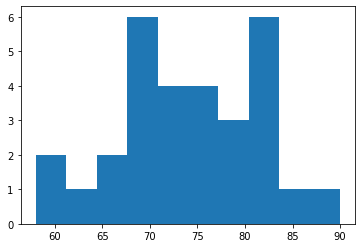

In [14]:
class_size = 30
quiz1_grades = [] 

for i in range(class_size):
    quiz1_grades.append(int(round(random.gauss(mu=75, sigma=10))))
    
plt.hist(quiz1_grades)

(array([1., 4., 6., 5., 4., 6., 3., 0., 0., 1.]),
 array([2.51 , 2.995, 3.48 , 3.965, 4.45 , 4.935, 5.42 , 5.905, 6.39 ,
        6.875, 7.36 ]),
 <a list of 10 Patch objects>)

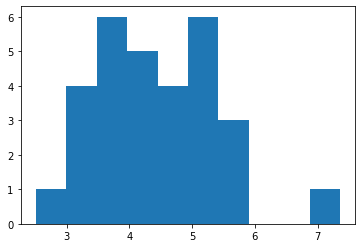

In [15]:
accesses = [fake_student_LMS_accesses(g) for g in quiz1_grades]
plt.hist(accesses)

(array([8., 8., 3., 3., 3., 2., 0., 0., 0., 3.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

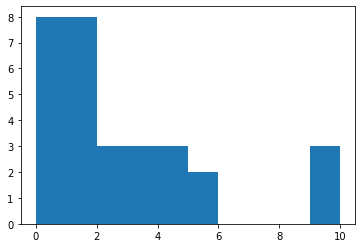

In [16]:
mess = [fake_student_LMS_mess(g, 3) for g in quiz1_grades]
plt.hist(mess)

---
### Fake data for one class:

In [17]:
def fake_class_basic_info(class_size):
    columns = ['id', 'f_name', 'l_name', 'gender', 'race', 'birth_dt', 'address', 'email']
    info_df = pd.DataFrame(columns=columns)
    
    possible_races = ['White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Mixed']
    race_prob = [0.763, 0.134, 0.013, 0.059, 0.002, 0.029]
    
    # Faker.seed(1234) # for producing the same results 
    fake = Faker()
    
    for s in range(class_size):
        student = {
            'id': fake.ssn(),
            'l_name': fake.last_name(),
            'gender': random.choice(['M', 'F']),
            'race': np.random.choice(possible_races, replace=True, p=race_prob),
            'birth_dt': fake.date_between_dates(date_start=datetime(1997, 1, 1), 
                                                date_end=datetime(2001, 12, 31)),
            'address': fake.address(),
            'email': fake.free_email()
        }    
        student['f_name'] = fake.first_name_male() if student['gender']=='M' else fake.first_name_female()
        
        info_df = info_df.append(student, ignore_index=True)
    
    return info_df

class20_basic_info = fake_class_basic_info(30)
class20_basic_info

,id,f_name,l_name,gender,race,birth_dt,address,email
0,538-63-1820,Jon,Garza,M,White,1997-08-03,"6789 Hubbard Mission\nNew Josephport, AL 05353",stewartjohn@hotmail.com
1,701-51-8830,Dana,Smith,F,White,1997-10-25,"562 William Knoll Apt. 437\nWest Julie, KY 21325",david66@hotmail.com
2,002-41-3824,Timothy,West,M,White,2000-01-07,"968 Barbara Center\nWest Seanview, CO 44852",owilson@gmail.com
3,002-57-4362,Peter,Cook,M,Black,1998-07-20,"50496 Kathryn Burgs\nEast Shannonmouth, TN 90510",mwalter@hotmail.com
4,407-12-2037,Paula,Hansen,F,White,2000-12-24,"1233 Reed Drive\nRamirezside, IL 49053",ofuentes@hotmail.com
5,863-90-9480,Christine,Mckinney,F,White,2001-04-05,"20677 Michael Mission\nBlackburgh, AR 72454",timothyhunter@hotmail.com
6,074-21-3359,Robert,Ortiz,M,White,2001-05-23,8702 George Island Suite 036\nSouth Rebeccamou...,zrivera@hotmail.com
7,199-28-7140,Sarah,Ashley,F,Mixed,1997-09-10,22586 Samantha Cliff Apt. 050\nSouth Darlenepo...,oschmidt@gmail.com
8,492-54-5720,Katie,Roy,F,White,2000-03-29,"942 Andrew Crossing\nMorganton, NH 79859",sheila56@hotmail.com
9,529-86-1639,Elizabeth,Reese,F,White,2001-09-26,"027 Bonnie Isle Apt. 198\nBrownstad, NJ 47992",taylor63@gmail.com


In [18]:
def fake_class_performance(class_size, n_mess_mu, grade1_mu, grade1_std, n_total_tests, n_avail_tests, 
                           n_total_home, n_avail_home, latest_home_idx, 
                           n_total_exams, n_avail_exams, exam1_idx, **paras):
    
    home_cols = ['home{}'.format(i+1) for i in range(n_total_home)]
    test_cols = ['test{}'.format(i+1) for i in range(n_total_tests)]
    exam_cols = ['exam{}'.format(i+1) for i in range(n_total_exams)]
    
    columns = ['ontime', 'late', 'missed', 'attendance', 'LMS_accesses', 'LMS_time', 'LMS_mess']
    columns = home_cols + test_cols + exam_cols + columns
        
    performance_df = pd.DataFrame(columns=columns)
    
    for st in range(class_size):
        st_all_gr, st_ho_gr, st_exam_gr, st_test_gr = fake_student_grades(grade1_mu, grade1_std, n_avail_tests, n_avail_home, 
                                                                          latest_home_idx, n_avail_exams, exam1_idx)
                
        ho_dict = {'home{}'.format(i+1): hg for i, hg in st_ho_gr.items()}
        test_dict = {'test{}'.format(i+1): tg for i, tg in st_test_gr.items()}
        exam_dict = {'exam{}'.format(i+1): eg for i, eg in st_exam_gr.items()}
        
        mean_gr = st_all_gr.mean()
        
        st_ontime, st_late, st_missed = fake_student_submission(mean_gr, st_ho_gr, **paras)
        st_attendance = fake_student_attendance(mean_gr, **paras)
        st_LMS_accesses = fake_student_LMS_accesses(mean_gr, **paras)
        st_LMS_time = fake_student_LMS_time(mean_gr, st_LMS_accesses, **paras)
        st_LMS_mess = fake_student_LMS_mess(mean_gr, n_mess_mu, **paras)
        
        student = {
            'ontime': st_ontime,
            'late': st_late,
            'missed': st_missed,
            'attendance': st_attendance,
            'LMS_accesses': st_LMS_accesses,
            'LMS_time': st_LMS_time,
            'LMS_mess': st_LMS_mess
        }
        
        student = {**student, **ho_dict, **test_dict, **exam_dict}
        
        performance_df = performance_df.append(student, ignore_index=True)
    
    return performance_df
        

args = {
    'class_size': 30, 
    'n_mess_mu': 2, 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_total_tests': 5, 
    'n_avail_tests': 2, 
    'n_total_home': 5, 
    'n_avail_home': 3, 
    'latest_home_idx': 4, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 1, 
    'exam1_idx': 3,       # idx starts at 0
}

class20_performance = fake_class_performance(**args)
class20_performance

,home1,home2,home3,home4,home5,test1,test2,test3,test4,test5,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess
0,86.0,86.0,87.0,NaN,NaN,88.0,83.0,NaN,NaN,NaN,86.0,NaN,92.87,7.13,0.0,100.00,6.25,5.60,0.0
1,79.0,81.0,77.0,NaN,NaN,78.0,74.0,NaN,NaN,NaN,76.0,NaN,94.76,5.24,0.0,100.00,3.97,4.93,3.0
2,80.0,77.0,76.0,NaN,NaN,78.0,76.0,NaN,NaN,NaN,75.0,NaN,80.85,19.15,0.0,94.89,2.64,4.68,1.0
3,82.0,78.0,76.0,NaN,NaN,78.0,76.0,NaN,NaN,NaN,75.0,NaN,94.65,5.35,0.0,100.00,4.63,4.26,1.0
4,80.0,75.0,75.0,NaN,NaN,77.0,75.0,NaN,NaN,NaN,74.0,NaN,95.55,4.45,0.0,95.51,4.46,6.22,0.0
5,81.0,82.0,77.0,NaN,NaN,81.0,77.0,NaN,NaN,NaN,78.0,NaN,92.86,7.14,0.0,100.00,5.20,4.61,2.0
6,74.0,75.0,69.0,NaN,NaN,74.0,71.0,NaN,NaN,NaN,72.0,NaN,84.00,16.00,0.0,100.00,3.80,5.19,1.0
7,87.0,86.0,89.0,NaN,NaN,89.0,87.0,NaN,NaN,NaN,87.0,NaN,82.77,17.23,0.0,100.00,5.94,5.42,0.0
8,78.0,81.0,83.0,NaN,NaN,79.0,82.0,NaN,NaN,NaN,79.0,NaN,80.95,19.05,0.0,88.26,3.41,5.54,2.0
9,78.0,80.0,80.0,NaN,NaN,78.0,79.0,NaN,NaN,NaN,78.0,NaN,85.13,14.87,0.0,100.00,6.73,2.22,2.0


In [19]:
# join on index to combine the two df
# assume there's no relationship bw basic info & academic performance

class20_df = class20_basic_info.join(class20_performance)
class20_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,test5,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess
0,538-63-1820,Jon,Garza,M,White,1997-08-03,"6789 Hubbard Mission\nNew Josephport, AL 05353",stewartjohn@hotmail.com,86.0,86.0,...,NaN,86.0,NaN,92.87,7.13,0.0,100.00,6.25,5.60,0.0
1,701-51-8830,Dana,Smith,F,White,1997-10-25,"562 William Knoll Apt. 437\nWest Julie, KY 21325",david66@hotmail.com,79.0,81.0,...,NaN,76.0,NaN,94.76,5.24,0.0,100.00,3.97,4.93,3.0
2,002-41-3824,Timothy,West,M,White,2000-01-07,"968 Barbara Center\nWest Seanview, CO 44852",owilson@gmail.com,80.0,77.0,...,NaN,75.0,NaN,80.85,19.15,0.0,94.89,2.64,4.68,1.0
3,002-57-4362,Peter,Cook,M,Black,1998-07-20,"50496 Kathryn Burgs\nEast Shannonmouth, TN 90510",mwalter@hotmail.com,82.0,78.0,...,NaN,75.0,NaN,94.65,5.35,0.0,100.00,4.63,4.26,1.0
4,407-12-2037,Paula,Hansen,F,White,2000-12-24,"1233 Reed Drive\nRamirezside, IL 49053",ofuentes@hotmail.com,80.0,75.0,...,NaN,74.0,NaN,95.55,4.45,0.0,95.51,4.46,6.22,0.0
5,863-90-9480,Christine,Mckinney,F,White,2001-04-05,"20677 Michael Mission\nBlackburgh, AR 72454",timothyhunter@hotmail.com,81.0,82.0,...,NaN,78.0,NaN,92.86,7.14,0.0,100.00,5.20,4.61,2.0
6,074-21-3359,Robert,Ortiz,M,White,2001-05-23,8702 George Island Suite 036\nSouth Rebeccamou...,zrivera@hotmail.com,74.0,75.0,...,NaN,72.0,NaN,84.00,16.00,0.0,100.00,3.80,5.19,1.0
7,199-28-7140,Sarah,Ashley,F,Mixed,1997-09-10,22586 Samantha Cliff Apt. 050\nSouth Darlenepo...,oschmidt@gmail.com,87.0,86.0,...,NaN,87.0,NaN,82.77,17.23,0.0,100.00,5.94,5.42,0.0
8,492-54-5720,Katie,Roy,F,White,2000-03-29,"942 Andrew Crossing\nMorganton, NH 79859",sheila56@hotmail.com,78.0,81.0,...,NaN,79.0,NaN,80.95,19.05,0.0,88.26,3.41,5.54,2.0
9,529-86-1639,Elizabeth,Reese,F,White,2001-09-26,"027 Bonnie Isle Apt. 198\nBrownstad, NJ 47992",taylor63@gmail.com,78.0,80.0,...,NaN,78.0,NaN,85.13,14.87,0.0,100.00,6.73,2.22,2.0


In [20]:
class20_df['course_code'] = 'CS_320'
class20_df['term_code'] = 'SP_2020' 
class20_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,course_code,term_code
0,538-63-1820,Jon,Garza,M,White,1997-08-03,"6789 Hubbard Mission\nNew Josephport, AL 05353",stewartjohn@hotmail.com,86.0,86.0,...,NaN,92.87,7.13,0.0,100.00,6.25,5.60,0.0,CS_320,SP_2020
1,701-51-8830,Dana,Smith,F,White,1997-10-25,"562 William Knoll Apt. 437\nWest Julie, KY 21325",david66@hotmail.com,79.0,81.0,...,NaN,94.76,5.24,0.0,100.00,3.97,4.93,3.0,CS_320,SP_2020
2,002-41-3824,Timothy,West,M,White,2000-01-07,"968 Barbara Center\nWest Seanview, CO 44852",owilson@gmail.com,80.0,77.0,...,NaN,80.85,19.15,0.0,94.89,2.64,4.68,1.0,CS_320,SP_2020
3,002-57-4362,Peter,Cook,M,Black,1998-07-20,"50496 Kathryn Burgs\nEast Shannonmouth, TN 90510",mwalter@hotmail.com,82.0,78.0,...,NaN,94.65,5.35,0.0,100.00,4.63,4.26,1.0,CS_320,SP_2020
4,407-12-2037,Paula,Hansen,F,White,2000-12-24,"1233 Reed Drive\nRamirezside, IL 49053",ofuentes@hotmail.com,80.0,75.0,...,NaN,95.55,4.45,0.0,95.51,4.46,6.22,0.0,CS_320,SP_2020
5,863-90-9480,Christine,Mckinney,F,White,2001-04-05,"20677 Michael Mission\nBlackburgh, AR 72454",timothyhunter@hotmail.com,81.0,82.0,...,NaN,92.86,7.14,0.0,100.00,5.20,4.61,2.0,CS_320,SP_2020
6,074-21-3359,Robert,Ortiz,M,White,2001-05-23,8702 George Island Suite 036\nSouth Rebeccamou...,zrivera@hotmail.com,74.0,75.0,...,NaN,84.00,16.00,0.0,100.00,3.80,5.19,1.0,CS_320,SP_2020
7,199-28-7140,Sarah,Ashley,F,Mixed,1997-09-10,22586 Samantha Cliff Apt. 050\nSouth Darlenepo...,oschmidt@gmail.com,87.0,86.0,...,NaN,82.77,17.23,0.0,100.00,5.94,5.42,0.0,CS_320,SP_2020
8,492-54-5720,Katie,Roy,F,White,2000-03-29,"942 Andrew Crossing\nMorganton, NH 79859",sheila56@hotmail.com,78.0,81.0,...,NaN,80.95,19.05,0.0,88.26,3.41,5.54,2.0,CS_320,SP_2020
9,529-86-1639,Elizabeth,Reese,F,White,2001-09-26,"027 Bonnie Isle Apt. 198\nBrownstad, NJ 47992",taylor63@gmail.com,78.0,80.0,...,NaN,85.13,14.87,0.0,100.00,6.73,2.22,2.0,CS_320,SP_2020


In [21]:
# Fake data for another term:
class19_basic_info = fake_class_basic_info(28)

args = {
    'class_size': 30, 
    'n_mess_mu': 3, 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_total_tests': 5, 
    'n_avail_tests': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5
}

class19_performance = fake_class_performance(**args)
class19_df = class19_basic_info.join(class19_performance)
class19_df['course_code'] = 'CS_320'
class19_df['term_code'] = 'SP_2019'

class19_df

,id,f_name,l_name,gender,race,birth_dt,address,email,home1,home2,...,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,course_code,term_code
0,703-92-8152,Nicole,Davenport,F,White,2001-01-16,"697 Powell Hills\nClineside, HI 73086",scrawford@hotmail.com,77.0,84.0,...,93.0,100.00,0.00,0.0,100.00,8.26,6.15,11.0,CS_320,SP_2019
1,201-60-3906,Susan,Whitehead,F,White,1998-10-04,"242 Ramirez Estates\nEast Robert, HI 61359",ashley98@gmail.com,83.0,80.0,...,83.0,100.00,0.00,0.0,100.00,5.89,3.34,1.0,CS_320,SP_2019
2,339-87-5538,Ryan,Hernandez,M,White,1997-08-15,"PSC 6011, Box 8370\nAPO AA 46929",nicholas50@gmail.com,69.0,67.0,...,59.0,74.14,25.86,0.0,70.08,3.56,3.69,1.0,CS_320,SP_2019
3,171-73-3941,Justin,Jenkins,M,White,2001-08-30,"63776 Cynthia Alley Suite 625\nJohnsonchester,...",gpetersen@hotmail.com,69.0,72.0,...,77.0,90.37,9.63,0.0,98.75,4.20,4.35,1.0,CS_320,SP_2019
4,862-66-9471,Gina,Nash,F,White,1997-07-10,"8126 Sarah Crest\nPort Austinshire, RI 72828",jonesjustin@gmail.com,84.0,84.0,...,93.0,96.65,3.35,0.0,100.00,6.67,7.30,4.0,CS_320,SP_2019
5,267-88-6805,Lisa,Sutton,F,White,2000-11-01,"55998 Huber Flats\nTracyfort, AZ 47419",morrisamber@yahoo.com,76.0,81.0,...,77.0,94.60,5.40,0.0,93.09,5.46,6.91,6.0,CS_320,SP_2019
6,052-13-4182,David,Allen,M,White,1998-01-04,"6430 Patrick Burgs Suite 434\nLake Isaac, NE 9...",saraherrera@gmail.com,69.0,71.0,...,74.0,84.38,15.62,0.0,96.34,4.54,3.15,8.0,CS_320,SP_2019
7,787-93-0274,Seth,Richardson,M,White,1998-12-06,"325 Williams Green\nNguyenside, DE 98660",harristammy@hotmail.com,89.0,86.0,...,82.0,98.98,1.02,0.0,97.96,6.29,7.30,1.0,CS_320,SP_2019
8,274-07-1098,Meghan,Pratt,F,White,1997-11-12,1272 Castillo Tunnel Apt. 459\nSouth Kristenfo...,kimberlyorozco@gmail.com,71.0,78.0,...,60.0,98.92,1.08,0.0,95.24,3.62,5.88,4.0,CS_320,SP_2019
9,870-57-9070,William,Lopez,M,White,1999-09-12,"316 Beasley Light\nEast Patrickside, NE 06573",oortiz@hotmail.com,74.0,78.0,...,79.0,100.00,0.00,0.0,100.00,5.58,5.62,1.0,CS_320,SP_2019


In [22]:
# export to an Excel file:
#with pd.ExcelWriter('CS_320.xlsx') as writer:  
    #class20_df.to_excel(writer, sheet_name='SP_2020', index=False)
    #class19_df.to_excel(writer, sheet_name='SP_2019', index=False)

In [23]:
# arguments hacking:

def fa(a, **arg):
    return a

def fb(b, **arg):
    return b

def fc(c, **arg):
    return c

def bigf(**args):
    return fa(**args) + fb(**args) + fc(**args)

bigf(a=4, b=5, c=6)

15

# Creating Database using SQLite

In [118]:
import sqlite3
conn = sqlite3.connect('Student_Data.db')
c = conn.cursor()

In [119]:
c.execute(""" DROP TABLE Student_Info""")

Creating table student information

In [120]:
c.execute("""CREATE TABLE Student_Info (
        id text PRIMARY KEY,
        f_name text,
        l_name text,
        gender text,
        race text,
        birth_dt numeric,
        address text,
        email text
        )""")

In [121]:
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd

student_data = class19_df
#print(student_data)
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_data, columns=['id', 'f_name','l_name','gender','race','birth_dt','address','email'])
df.to_sql('Student_Info', con=engine, if_exists='append',index = False)
x = engine.execute('''SELECT * FROM Student_Info''')
for row in x.fetchmany(5):
    print (row)
x.close()    
#engine.commit()   

('703-92-8152', 'Nicole', 'Davenport', 'F', 'White', '2001-01-16', '697 Powell Hills\nClineside, HI 73086', 'scrawford@hotmail.com')
('201-60-3906', 'Susan', 'Whitehead', 'F', 'White', '1998-10-04', '242 Ramirez Estates\nEast Robert, HI 61359', 'ashley98@gmail.com')
('339-87-5538', 'Ryan', 'Hernandez', 'M', 'White', '1997-08-15', 'PSC 6011, Box 8370\nAPO AA 46929', 'nicholas50@gmail.com')
('171-73-3941', 'Justin', 'Jenkins', 'M', 'White', '2001-08-30', '63776 Cynthia Alley Suite 625\nJohnsonchester, ND 79163', 'gpetersen@hotmail.com')
('862-66-9471', 'Gina', 'Nash', 'F', 'White', '1997-07-10', '8126 Sarah Crest\nPort Austinshire, RI 72828', 'jonesjustin@gmail.com')


In [122]:
conn.commit()


Creating table Student profile

In [137]:
c.execute(""" DROP TABLE StudentProfile""")

In [138]:
c.execute("""CREATE TABLE StudentProfile (
        id text ,
        course_code text,
        term_code text,
        PRIMARY KEY (course_code, id)
        FOREIGN KEY(id) REFERENCES Student_Info(id)
        )""")

In [139]:
student_prof = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_prof, columns=['id', 'course_code', 'term_code'])
df.to_sql('StudentProfile', con=engine, if_exists='append',index = False)
p = engine.execute('''SELECT rowid, id, course_code, term_code  FROM StudentProfile''')
for row in p.fetchmany(5):
    print (row)
p.close()  

(1, '703-92-8152', 'CS_320', 'SP_2019')
(2, '201-60-3906', 'CS_320', 'SP_2019')
(3, '339-87-5538', 'CS_320', 'SP_2019')
(4, '171-73-3941', 'CS_320', 'SP_2019')
(5, '862-66-9471', 'CS_320', 'SP_2019')


In [140]:
conn.commit()

Creating table for Home assignments

In [141]:
c.execute(""" DROP TABLE Assignment""")

In [142]:
c.execute("""CREATE TABLE Assignment (
        assignID integer PRIMARY KEY AUTOINCREMENT,
        home1 real,
        home2 real,
        home3 real,
        home4 real,
        home5 real,
        course_code text,
        id text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [143]:
home_assignment = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(student_prof, columns=['home1', 'home2', 'home3','home4','home5','course_code','id'])
df.to_sql('Assignment', con=engine, if_exists='append',index = False)
y = engine.execute('''SELECT * FROM Assignment''')
for row in y.fetchmany(5):
    print (row)
y.close()  

(1, 77.0, 84.0, 84.0, 92.0, 90.0, 'CS_320', '703-92-8152')
(2, 83.0, 80.0, 80.0, 83.0, 84.0, 'CS_320', '201-60-3906')
(3, 69.0, 67.0, 65.0, 62.0, 61.0, 'CS_320', '339-87-5538')
(4, 69.0, 72.0, 77.0, 70.0, 75.0, 'CS_320', '171-73-3941')
(5, 84.0, 84.0, 87.0, 89.0, 95.0, 'CS_320', '862-66-9471')


In [144]:
conn.commit()

Creating table for tests and exams

In [145]:
c.execute(""" DROP TABLE Assessment""")

In [146]:
c.execute("""CREATE TABLE Assessment (
        testID integer PRIMARY KEY AUTOINCREMENT,
        test1 real,
        test2 real,
        test3 real,
        test4 real,
        test5 real,
        exam1 real,
        exam2 real,
        id text,
        course_code text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [147]:
class_assessment = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(class_assessment, columns=['test1', 'test2', 'test3','test4','test5', 'exam1','exam2','course_code','id'])
df.to_sql('Assessment', con=engine, if_exists='append',index = False)
n = engine.execute('''SELECT * FROM Assessment''')
for row in n.fetchmany(5):
    print (row)
n.close()  

(1, 80.0, 82.0, 86.0, 90.0, 91.0, 84.0, 93.0, '703-92-8152', 'CS_320')
(2, 82.0, 77.0, 79.0, 78.0, 83.0, 79.0, 83.0, '201-60-3906', 'CS_320')
(3, 68.0, 65.0, 63.0, 64.0, 58.0, 66.0, 59.0, '339-87-5538', 'CS_320')
(4, 68.0, 77.0, 76.0, 71.0, 75.0, 75.0, 77.0, '171-73-3941', 'CS_320')
(5, 82.0, 84.0, 88.0, 89.0, 89.0, 81.0, 93.0, '862-66-9471', 'CS_320')


In [148]:
conn.commit()

Creating table for student tracking

In [149]:
c.execute(""" DROP TABLE Student_track""")

In [150]:
c.execute("""CREATE TABLE Student_track (
        trackID integer PRIMARY KEY AUTOINCREMENT,
        ontime real,
        late real,
        missed real,
        attendance real,
        LMS_accesses real,
        LMS_time real,
        LMS_mess real,
        id text,
        course_code text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [151]:
studenTrack = class19_df
engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
df = pd.DataFrame(studenTrack, columns=['ontime', 'late', 'missed', 'attendance','LMS_accesses','LMS_time', 'LMS_mess','course_code','id'])
df.to_sql('Student_track', con=engine, if_exists='append',index = False)
z = engine.execute('''SELECT * FROM Student_track''')
for row in z.fetchmany(5):
    print (row)
z.close()  

(1, 100.0, 0.0, 0.0, 100.0, 8.26, 6.15, 11.0, '703-92-8152', 'CS_320')
(2, 100.0, 0.0, 0.0, 100.0, 5.89, 3.34, 1.0, '201-60-3906', 'CS_320')
(3, 74.14, 25.86, 0.0, 70.08, 3.56, 3.69, 1.0, '339-87-5538', 'CS_320')
(4, 90.37, 9.63, 0.0, 98.75, 4.2, 4.35, 1.0, '171-73-3941', 'CS_320')
(5, 96.65, 3.35, 0.0, 100.0, 6.67, 7.3, 4.0, '862-66-9471', 'CS_320')


In [152]:
conn.commit()

queries for testing

In [153]:
## Selecting only Female students

c.execute("SELECT * FROM Student_info WHERE gender=='F'")
items = c.fetchmany(5)
for x in items:
    print(x)

('703-92-8152', 'Nicole', 'Davenport', 'F', 'White', '2001-01-16', '697 Powell Hills\nClineside, HI 73086', 'scrawford@hotmail.com')
('201-60-3906', 'Susan', 'Whitehead', 'F', 'White', '1998-10-04', '242 Ramirez Estates\nEast Robert, HI 61359', 'ashley98@gmail.com')
('862-66-9471', 'Gina', 'Nash', 'F', 'White', '1997-07-10', '8126 Sarah Crest\nPort Austinshire, RI 72828', 'jonesjustin@gmail.com')
('267-88-6805', 'Lisa', 'Sutton', 'F', 'White', '2000-11-01', '55998 Huber Flats\nTracyfort, AZ 47419', 'morrisamber@yahoo.com')
('274-07-1098', 'Meghan', 'Pratt', 'F', 'White', '1997-11-12', '1272 Castillo Tunnel Apt. 459\nSouth Kristenfort, WA 20170', 'kimberlyorozco@gmail.com')


In [154]:
## student attendance < 70%
c.execute("SELECT s.id, s.f_name, s.l_name, t.attendance FROM Student_info s, Student_track t WHERE t.id = s.id AND t.attendance < 70")
items = c.fetchmany(5)
for x in items:
    print(x)

('537-20-8279', 'Mark', 'Quinn', 69.85)
('056-51-5246', 'Holly', 'Hoffman', 55.2)
('857-77-4611', 'Dawn', 'Butler', 62.9)
('008-86-3690', 'Sarah', 'Gaines', 42.58)
('792-48-1769', 'Angela', 'Palmer', 54.27)


In [155]:
conn.commit()
conn.close()